In [1]:
#####################################################################
# This notebook is authored by: Ayan Paul & Lina Alasfar            #
# Date: May 2022                                                    #
# If you use this code or the results from this work please cite:   # 
# Machine learning the trilinear and light-quark Yukawa couplings   #
# from Higgs pair kinematic shapes                                  #
# Lina Alasfar, Ramona Gröber, Christophe Grojean, Ayan Paul        #
# and Zuoni Qian                                                    #
# arXiv:2205.XXXXX (https://arxiv.org/abs/2005.XXXXX)               # 
#####################################################################

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import corner as crn
import math
import arviz as az
import os
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
import json
from sigma_br_FCC_hh import *
from matplotlib.ticker import AutoMinorLocator
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'monospace'
## ***************************************************************************
## * RC param                                                                 *
## ***************************************************************************
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 1
## ***************************************************************************

NBINS = 100

with open('../results/confusion/FCC-hh-BDT/hh-BDT-6class-ku.confusion.json') as f:
    confusion_u = json.load(f)
    
with open('../results/confusion/FCC-hh-BDT/hh-BDT-6class-kd.confusion.json') as f:
    confusion_d = json.load(f)
    
with open('../results/confusion/FCC-hh-BDT/hh-BDT-5class-ku-kd.confusion.json') as f:
    confusion_ud = json.load(f)
    
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)

kltoCH = lambda x : LambdaNP2/v4*mh2*0.5*(1-x)
kutoCuH = lambda x : LambdaNP2/v3*(sqrt_2*2.2e-3*(1-x))
kdtoCdH = lambda x : LambdaNP2/v3*(sqrt_2*4.7e-3*(1-x))
CuHtoku = lambda x:  1 - (x/sqrt_2/LambdaNP2 * v3/2.2e-3)
CdHtokd = lambda x:  1 - (x/sqrt_2/LambdaNP2 * v3/4.7e-3)
unity = lambda x : x

In [2]:
def likelihood_u(x, y):
    z3_lim = sigmahh_kukl(1., 1., 'ku', confusion_u)
    z4_lim = sigmahh_kukl(1., 1., 'tri', confusion_u)
    z5_lim = sigmahh_kukl(1., 1., 'int', confusion_u)
    
    return -((sigmahh_kukl(x, y, 'ku', confusion_u) - z3_lim)**2/z3_lim 
            + (sigmahh_kukl(x, y, 'tri', confusion_u) - z4_lim)**2/z4_lim
            + (sigmahh_kukl(x, y, 'int', confusion_u) - z5_lim)**2/z5_lim
            ) * 0.5

def likelihood_d(x, y):
    z3_lim = sigmahh_kdkl(1., 1., 'kd', confusion_d)
    z4_lim = sigmahh_kdkl(1., 1., 'tri', confusion_d)
    z5_lim = sigmahh_kdkl(1., 1., 'int', confusion_d)
    
    return -((sigmahh_kdkl(x, y, 'kd', confusion_d) - z3_lim)**2/z3_lim 
            + (sigmahh_kdkl(x, y, 'tri', confusion_d) - z4_lim)**2/z4_lim
            + (sigmahh_kdkl(x, y, 'int', confusion_d) - z5_lim)**2/z5_lim
            ) * 0.5

def likelihood_ud(x, y):
    z3_lim = sigmahh_kukd(1., 1., 'ku', confusion_ud)
    z4_lim = sigmahh_kukd(1., 1., 'kd', confusion_ud)
    
    return -((sigmahh_kukd(x, y, 'ku', confusion_ud) - z3_lim)**2/z3_lim 
            + (sigmahh_kukd(x, y, 'kd', confusion_ud) - z4_lim)**2/z4_lim
            ) * 0.5


def runMCMC(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        k1 = pm.Uniform('k1', lower=limits[0], upper=limits[1])
        k2 = pm.Uniform('k2', lower=limits[2], upper=limits[3])

        like = pm.Potential('like', likelihood(k1, k2))
        
    if fit:
        with model:
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
            if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
        return trace, model
    return model

def makeCorner(trace, model, filename, collider, label, limit, lambdas=[unity, unity]):
    """ Corner plot builder
    argument:
        trace: the trace from the pyMC3 run
        filename: the file to save the plot in
        collider: a string with the collider name to attach to the plot
        label: the label for the axes corresponding to the variables (couplings)
        limit: the limit on the variables (couplings)
        lambdas: the conversion lambdas from kappa to Wilson coefficients
    """
    var = ['k1', 'k2']
    samples = np.vstack((lambdas[0](trace['k1']), lambdas[1](trace['k2']))).T
    tr = pd.DataFrame(samples)
    corr=tr.corr()[1][0]*100

    if lambdas[0] != unity:
        limit_t = np.array(limit)
        limit_t[0] = lambdas[0](limit[1])
        limit_t[1] = lambdas[0](limit[0])
        limit_t[2] = lambdas[1](limit[3])
        limit_t[3] = lambdas[1](limit[2])
        limits = limit_t
    else: limits = limit

        
    fig = plt.figure(figsize=(10,10))
    fig = crn.corner(samples,labels = [label[0], label[1]], 
                     truths = None, bins=NBINS,
                     show_titles=True, title_kwargs={"fontsize": 32}, label_kwargs={"fontsize": 30},
                     levels=(0.6827,0.9545,0.9973), 
                     plot_contours = True, fill_contours=True, smooth=True, smooth1d=None,
                     plot_datapoints = False, color='#bb9cb1', labelpad=-0.13, fig=fig, title_fmt='.3f', hist_kwargs={'linewidth': 2, 'histtype': 'bar'}, 
                     range=[(limits[0], limits[1]), (limits[2], limits[3])], truth_color='#343434')
    
    stats_func_1 = {
        'b0': lambda x: multimode(x, 0, 0.6827),
        'b1': lambda x: multimode(x, 1, 0.6827),
        }
    
    stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
    
    stats_func_3 = {
        'b0': lambda x: multimode(x, 0, 0.9973),
        'b1': lambda x: multimode(x, 1, 0.9973),
        }
    
    df_1 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.6827, round_to='none', stat_funcs=stats_func_1))
    df_2 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
    df_3 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.9973, round_to='none', stat_funcs=stats_func_3))

    for ax in fig.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', labelsize=26, rotation=0)
        ax.tick_params(axis='x', labelsize=26, rotation=30)


    
    ax = fig.get_axes()
    ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off)
      )
    ax[3].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off)
      )
    
    for j in range(2):
        for i in range(NBINS):
            
            lim_1l = min(lambdas[j](df_1.loc[var[j]]['b0']), lambdas[j](df_1.loc[var[j]]['b1']))
            lim_1u = max(lambdas[j](df_1.loc[var[j]]['b0']), lambdas[j](df_1.loc[var[j]]['b1']))
            
            lim_2l = min(lambdas[j](df_2.loc[var[j]]['b0']), lambdas[j](df_2.loc[var[j]]['b1']))
            lim_2u = max(lambdas[j](df_2.loc[var[j]]['b0']), lambdas[j](df_2.loc[var[j]]['b1']))
            
            lim_3l = min(lambdas[j](df_3.loc[var[j]]['b0']), lambdas[j](df_3.loc[var[j]]['b1']))
            lim_3u = max(lambdas[j](df_3.loc[var[j]]['b0']), lambdas[j](df_3.loc[var[j]]['b1']))
            
            if ax[3*j].patches[i].xy[0] > lim_1l and ax[3*j].patches[i].xy[0] < lim_1u:
                ax[3*j].patches[i].set_alpha(1)
            elif ax[3*j].patches[i].xy[0] > lim_2l and ax[3*j].patches[i].xy[0] < lim_2u:
                ax[3*j].patches[i].set_alpha(0.5)
            elif ax[3*j].patches[i].xy[0] > lim_3l and ax[3*j].patches[i].xy[0] < lim_3u:
                ax[3*j].patches[i].set_alpha(0.25)
            else:
                ax[3*j].patches[i].set_alpha(0.1)
    
    
    ## 1D histogram labels
    ax[0].set_title(label[0]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[0](df_1.loc['k1']['hdi_84.135%']), lambdas[0](df_1.loc['k1']['hdi_15.865%'])), fontsize=28)
    ax[3].set_title(label[1]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[1](df_1.loc['k2']['hdi_84.135%']), lambdas[1](df_1.loc['k2']['hdi_15.865%'])), fontsize=28)

    ## title
    ax[1].annotate(collider, xy=(0.5, 0.7), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=32, fontweight='bold')
    ax[1].annotate('Best Fit Point:', xy=(0.5, 0.6), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=28)
    ax[1].annotate(label[0]+r'$ = 0.0$', xy=(0.5, 0.5), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=28)
    ax[1].annotate(label[1]+r'$ = 0.0$', xy=(0.5, 0.4), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=28)

    ## grid
    ax[2].grid(linestyle=':', zorder=0)
    
    plt.tight_layout()
    fig.savefig(filename,dpi=300, transparent=True,bbox_inches='tight')
    plt.show()

def mode(x):
    """ Finds the mode of x
        argument:
            x: an array
    """
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def multimode(x, n, hdi_prob):
    """ Finds all the modes in the distribution
        arguments:
            x: the array for the distribution
            n: the identifier for the variable
    """
    md = az.hdi(x, hdi_prob=hdi_prob, multimodal=False)
    if len(md) < 2 and n > 1:
        return np.NaN
    else:
        return md[n%2]

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 4000
Interrupted at 3,999 [1%]: Average Loss = 3.3257
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k2, k1]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 1414 seconds.


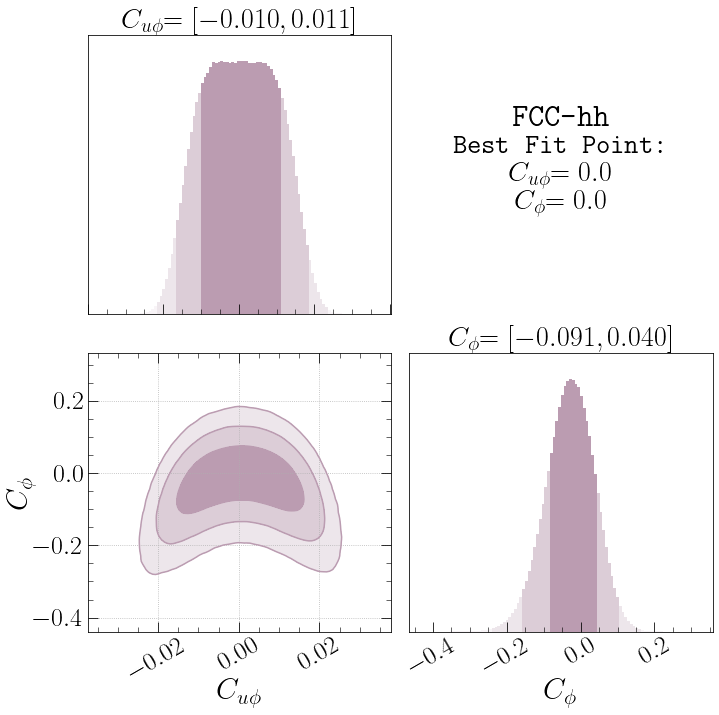

In [3]:
## FCC-hh ku
limits = [-175., 175., 0.85, 1.2]
config = [150000, 0.8, 50]
trace_ku, model_ku = runMCMC(likelihood_u, limits, config=config)
filename = '../plots/kappa_u-kappa_l-FCC-hh.pdf'
makeCorner(trace_ku, model_ku, filename, collider='FCC-hh', label=[r"$C_{u\phi}$", r"$C_\phi$"],  limit=limits,
           lambdas=[kutoCuH, kltoCH])

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 3700
Interrupted at 3,699 [1%]: Average Loss = 13.563
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k2, k1]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 2191 seconds.
The number of effective samples is smaller than 25% for some parameters.


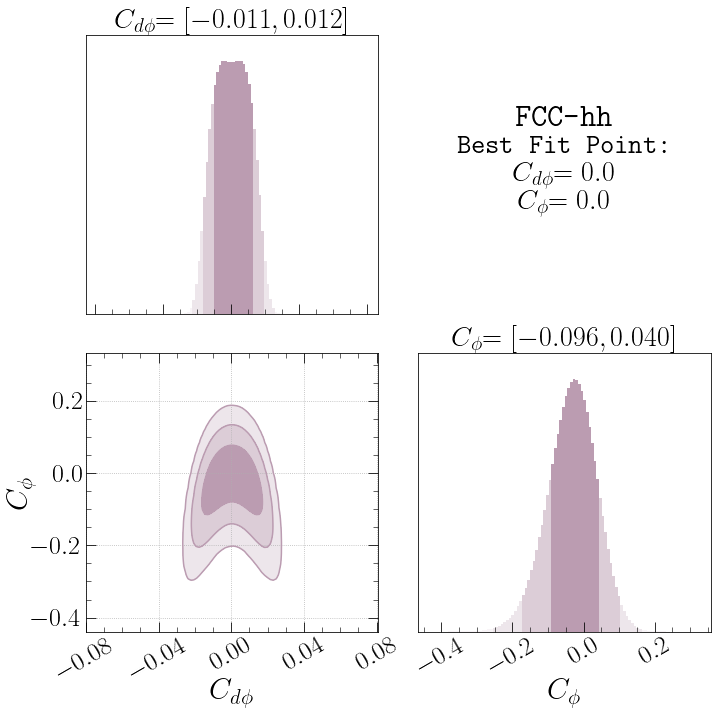

In [4]:
## FCC-hh kd
limits = [-175., 175., 0.85, 1.2]
config = [150000, 0.95, 50]
trace_kd, model_kd = runMCMC(likelihood_d, limits, config=config)
filename = '../plots/kappa_d-kappa_l-FCC-hh.pdf'
makeCorner(trace_kd, model_kd, filename, collider='FCC-hh', label=[r"$C_{d\phi}$", r"$C_\phi$"],  limit=limits,
           lambdas=[kdtoCdH, kltoCH])

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 6300
Interrupted at 6,299 [3%]: Average Loss = 11.084
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k2, k1]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 2183 seconds.


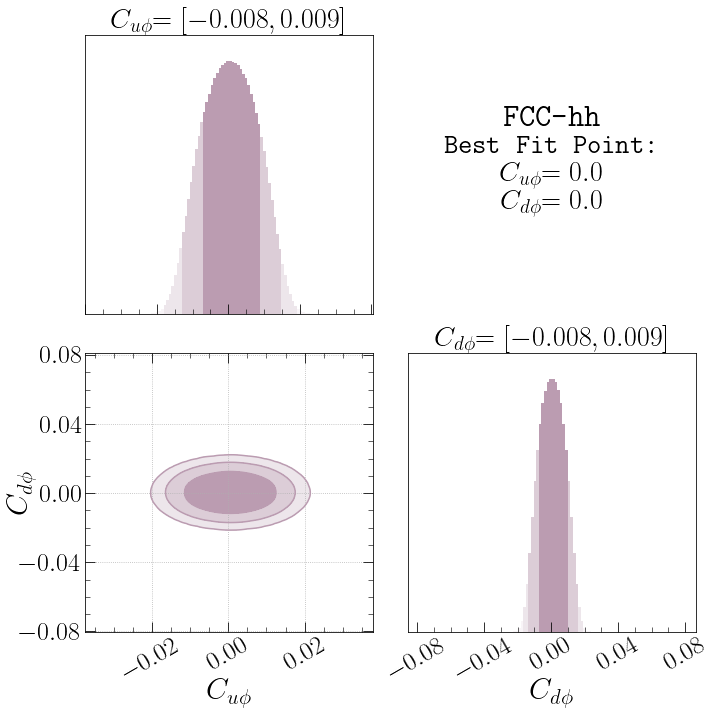

In [5]:
## FCC-hh ku kd
limits = [-175., 175., -175., 175.]
config = [150000, 0.95, 50]
trace_ku_kd, model_ku_kd = runMCMC(likelihood_ud, limits, config=config)
filename = '../plots/kappa_u-kappa_d-FCC-hh.pdf'
makeCorner(trace_ku_kd, model_ku_kd, filename, collider='FCC-hh', label=[r"$C_{u\phi}$", r"$C_{d\phi}$"],  limit=limits,
           lambdas=[kutoCuH, kdtoCdH])